In [1]:
import numpy as np
import pandas as pd

In [14]:
import os
import tensorflow as tf
import tensorflow_hub as hub

In [7]:
df_cross = pd.read_csv('df_cross.csv').iloc[:,1:]

In [8]:
df_cross.head()

,reviewer_id,preference,listing_id,host_is_superhost,latitude,longitude,price,number_of_reviews_ltm,calculated_host_listings_count,nearby_sites_rating,nearest_station_dist,host_response_time_cross_rate,item_factor_0,user_factor_0,item_factor_1,user_factor_1,item_factor_2,user_factor_2,item_factor_3,user_factor_3,item_factor_4,user_factor_4,item_factor_5,user_factor_5,item_factor_6,user_factor_6,item_factor_7,user_factor_7,item_factor_8,user_factor_8,item_factor_9,user_factor_9,text_factor_0,text_factor_1,text_factor_2,text_factor_3,text_factor_4,text_factor_5,text_factor_6,text_factor_7,...,text_factor_60,text_factor_61,text_factor_62,text_factor_63,text_factor_64,text_factor_65,text_factor_66,text_factor_67,text_factor_68,text_factor_69,text_factor_70,text_factor_71,text_factor_72,text_factor_73,text_factor_74,text_factor_75,text_factor_76,text_factor_77,text_factor_78,text_factor_79,text_factor_80,text_factor_81,text_factor_82,text_factor_83,text_factor_84,text_factor_85,text_factor_86,text_factor_87,text_factor_88,text_factor_89,text_factor_90,text_factor_91,text_factor_92,text_factor_93,text_factor_94,text_factor_95,text_factor_96,text_factor_97,text_factor_98,text_factor_99
0,8557223,0.916301,49091,0,1.44255,103.79580,79.0,0,2,0.995731,0.617762,2.0,-0.080090,-0.045423,-0.072907,0.119669,0.077274,0.045258,0.037663,0.085235,-0.038879,0.009194,0.038809,-0.038233,0.030629,-0.072737,0.032604,0.082893,0.287333,-0.098187,0.089866,0.021846,0.142089,0.000000,0.018916,0.0,0.0,0.0,0.0,0.0,...,0.044367,0.0,0.0,0.0,0.287722,0.0,0.091301,0.0,0.0,0.044881,0.000000,0.0,0.000000,0.000000,0.0,0.047507,0.108294,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.03517,0.0,0.04369,0.042906,0.0,0.0,0.0,0.030842,0.058244,0.0,0.184618,0.020374,0.044663,0.0,0.020237,0.0
1,1356099,0.919923,50646,0,1.33235,103.78521,80.0,0,1,1.269606,0.399696,0.0,0.081554,-0.049855,-0.105953,0.044933,-0.116901,0.131527,-0.017028,0.111009,-0.086785,-0.002848,-0.020847,0.074678,-0.037473,-0.052219,-0.075626,-0.012367,0.034406,0.001945,0.085947,0.008726,0.000000,0.092355,0.046490,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.149175,0.0,0.076165,0.089894,0.0,0.000000,0.133081,0.058977,0.0,0.0,0.0,0.088774,0.098758,0.0,0.08644,0.0,0.00000,0.000000,0.0,0.0,0.0,0.075802,0.214724,0.0,0.000000,0.050074,0.109771,0.0,0.049738,0.0
2,15222393,0.938573,50646,0,1.33235,103.78521,80.0,0,1,1.269606,0.399696,0.0,0.081554,-0.045758,-0.105953,-0.057649,-0.116901,-0.014033,-0.017028,0.041884,-0.086785,0.181634,-0.020847,-0.046492,-0.037473,-0.133720,-0.075626,-0.118024,0.034406,0.067946,0.085947,-0.158080,0.000000,0.092355,0.046490,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.149175,0.0,0.076165,0.089894,0.0,0.000000,0.133081,0.058977,0.0,0.0,0.0,0.088774,0.098758,0.0,0.08644,0.0,0.00000,0.000000,0.0,0.0,0.0,0.075802,0.214724,0.0,0.000000,0.050074,0.109771,0.0,0.049738,0.0
3,5543172,0.926675,50646,0,1.33235,103.78521,80.0,0,1,1.269606,0.399696,0.0,0.081554,0.028973,-0.105953,0.145273,-0.116901,0.066612,-0.017028,-0.063751,-0.086785,0.176873,-0.020847,-0.142651,-0.037473,0.024285,-0.075626,0.007321,0.034406,0.025454,0.085947,0.055499,0.000000,0.092355,0.046490,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.149175,0.0,0.076165,0.089894,0.0,0.000000,0.133081,0.058977,0.0,0.0,0.0,0.088774,0.098758,0.0,0.08644,0.0,0.00000,0.000000,0.0,0.0,0.0,0.075802,0.214724,0.0,0.000000,0.050074,0.109771,0.0,0.049738,0.0
4,817532,0.910008,50646,0,1.33235,103.78521,80.0,0,1,1.269606,0.399696,0.0,0.081554,-0.055366,-0.105953,-0.037461,-0.116901,0.030717,-0.017028,0.059124,-0.086785,0.139225,-0.020847,0.046353,-0.037473,-0.032285,-0.075626,-0.020036,0.034406,0.008693,0.085947,-0.050897,0.000000,0.092355,0.046490,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.149175,0.0,0.076165,0.089894,0.0,0.000000,0.133081,0.058977,0.0,0.0,0.0,0.088774,0.098758,0.0,0.0864

In [27]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('preference')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [29]:
from sklearn.model_selection import train_test_split

batch_size = 128 

train, test = train_test_split(df_cross.astype({'listing_id':'string','number_of_reviews_ltm':'float64','calculated_host_listings_count':'float64'}), test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [24]:
# Determine csv and label columns
num_factor = 10
text_feat = 100

NON_FACTOR_COLUMNS = ["preference", 'listing_id',
       'host_is_superhost', 'latitude',
       'longitude','price','number_of_reviews_ltm','calculated_host_listings_count','nearby_sites_rating',
       'nearest_station_dist', 'host_response_time_cross_rate']
FACTOR_COLUMNS1 = ["user_factor_{}".format(i) for i in range(num_factor)] + ["item_factor_{}".format(i) for i in range(num_factor)]
FACTOR_COLUMNS2 = ["text_factor_{}".format(i) for i in range(text_feat)] 
CSV_COLUMNS = NON_FACTOR_COLUMNS + FACTOR_COLUMNS1 + FACTOR_COLUMNS2
LABEL_COLUMN = "preference"

# Set default values for each CSV column
NON_FACTOR_DEFAULTS = [[0.0],['Unknown'],[0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]]
FACTOR_DEFAULTS1 = [[0.0] for i in range(num_factor)] + [[0.0] for i in range(num_factor)] # user and item
FACTOR_DEFAULTS2 = [[0.0] for i in range(text_feat)]
DEFAULTS = NON_FACTOR_DEFAULTS + FACTOR_DEFAULTS1 + FACTOR_DEFAULTS2

In [22]:
lat_min = df_cross.latitude.min()
lat_max = df_cross.latitude.max()

lon_min = df_cross.longitude.min()
lon_max = df_cross.longitude.max()

norl_mean = df_cross.number_of_reviews_ltm.mean()
norl_std = df_cross.number_of_reviews_ltm.std()

chlc_mean = df_cross.calculated_host_listings_count.mean()
chlc_std = df_cross.calculated_host_listings_count.std()

nsr_mean = df_cross.nearby_sites_rating.mean()
nsr_std = df_cross.nearby_sites_rating.std()

nsd_mean = df_cross.nearest_station_dist.mean()
nsd_std = df_cross.nearest_station_dist.std()

In [34]:
listing_id_embedings = 50
number_of_listing_id = df_cross.listing_id.nunique()

# # Input listing id
# input_lst_id = tf.layers.Input(shape=[1],name='lst_id_input')
# embed_lst_id = tf.layers.Embedding(n_listing_id + 1,listing_id_embedings)(input_lst_id)
# out_lst_id = tf.layers.Flatten()(embed_lst_id)

# # Input superhost
# input_sp_host = tf.layers.Input(shape=[1],name='sp_host_input')
# cate_sp_host = 

# Create feature columns to be used in model
def create_feature_columns():
    # Create description feature column
    # embedded_description_column = hub.text_embedding_column(
    #     key = "dtld_descr", 
    #     module_spec = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
    #     trainable = False)

    # Create listing id feature column
    feature_layer_inputs = {}

    listing_id_column = tf.feature_column.categorical_column_with_hash_bucket(
        key = "listing_id",
        hash_bucket_size = number_of_listing_id)
    
    feature_layer_inputs['listing_id'] = tf.keras.Input(shape=(1,), name='listing_id', dtype=tf.string)

    embedded_listing_id_column = tf.feature_column.embedding_column(
        categorical_column = listing_id_column,
        dimension = listing_id_embedings)    

    # Create superhost feature column
    categorical_superhost_column = tf.feature_column.categorical_column_with_identity(
        key = 'host_is_superhost',
        num_buckets = 2)
    
    feature_layer_inputs['host_is_superhost'] = tf.keras.Input(shape=(1,), name='host_is_superhost', dtype=tf.int64)
    
    indicator_superhost_column = tf.feature_column.indicator_column(
        categorical_column = categorical_superhost_column
    )

    # Create bucketized price column
    bucketized_price_column = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column(key = 'price'),
        boundaries=list(np.arange(0,1000,100)))
    
    feature_layer_inputs['price'] = tf.keras.Input(shape=(1,), name='price', dtype=tf.float64)

    # Create numeric columns: 'number_of_reviews_ltm','calculated_host_listings_count','nearby_sites_rating',
    #'nearest_station_dist','host_response_time_cross_rate'

    number_of_reviews_ltm_column = tf.feature_column.numeric_column(
        key = 'number_of_reviews_ltm', 
        normalizer_fn=lambda x:(x-norl_mean) / norl_std)
    
    calculated_host_listings_count_column = tf.feature_column.numeric_column(
        key = 'calculated_host_listings_count',
        normalizer_fn=lambda x:(x-chlc_mean) / chlc_std)
    
    nearby_sites_rating_column = tf.feature_column.numeric_column(
        key = 'nearby_sites_rating',
        normalizer_fn=lambda x:(x-nsr_mean) / nsr_std)
    
    nearest_station_dist_column = tf.feature_column.numeric_column(
        key = 'nearest_station_dist',
        normalizer_fn=lambda x:(x-nsd_mean) / nsd_std)

    host_response_time_cross_rate_column = tf.feature_column.numeric_column(
        key = 'host_response_time_cross_rate')
    
    for feat in NON_FACTOR_COLUMNS[3:]:
      feature_layer_inputs[feat] = tf.keras.Input(shape=(1,), name=feat, dtype=tf.float64)
  
    # Create lat,lon boundaries list for our binning
    lat_boundaries = list(np.arange(lat_min, lat_max+0.01, 0.05))
    lon_boundaries = list(np.arange(lon_min, lon_max+0.01, 0.05))

    lat_column = tf.feature_column.numeric_column(
        key = "latitude")
    lon_column = tf.feature_column.numeric_column(
        key = "longitude")   
    
    # Create bucketized lat,lon feature column using our boundaries
    lat_bucketized_column = tf.feature_column.bucketized_column(
        source_column = lat_column,
        boundaries = lat_boundaries)
    
    lon_bucketized_column = tf.feature_column.bucketized_column(
        source_column = lon_column,
        boundaries = lon_boundaries)    
    
    # Cross bucketized lat column and bucketized lon column
    crossed_lat_lon_column = tf.feature_column.crossed_column(
        keys = [lat_bucketized_column, lon_bucketized_column],
        hash_bucket_size = len(lat_bucketized_column) * len(lon_bucketized_column))

    # Convert crossed categorical category and bucketized months since epoch column into indicator column so that it can be used in a DNN
    indicator_crossed_lat_lon_column = tf.feature_column.indicator_column(
            categorical_column = crossed_lat_lon_column)    

    # Create user and item factor feature columns from our trained WALS model
    user_factors = [tf.feature_column.numeric_column(key = "user_factor_" + str(i)) for i in range(num_factor)]
    item_factors =  [tf.feature_column.numeric_column(key = "item_factor_" + str(i)) for i in range(num_factor)]
    text_factors = [tf.feature_column.numeric_column(key = "text_factor_" + str(i)) for i in range(text_feat)]

    for factor in FACTOR_COLUMNS1+FACTOR_COLUMNS2:
      feature_layer_inputs[factor] = tf.keras.Input(shape=(1,), name=factor, dtype=tf.float64)

    # Create list of feature columns
    feature_columns = [#embedded_description_column,
      embedded_listing_id_column,           
      indicator_superhost_column,
      bucketized_price_column,
      calculated_host_listings_count_column,
      nearby_sites_rating_column,
      nearest_station_dist_column,
      host_response_time_cross_rate_column,
      indicator_crossed_lat_lon_column] + user_factors + item_factors + text_factors

    return feature_columns, feature_layer_inputs

In [35]:
# Model Parameters:
layers = [256, 128, 64]
C=0.04
dropout_rate=0.25
learning_rate=0.1

feature_columns, feature_layer_inputs = create_feature_columns()

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer_outputs = x = feature_layer(feature_layer_inputs)

# Define the hidden layers
for index, layer in enumerate(layers):
  x = tf.keras.layers.Dense(units=layer, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(C),
                                  name=f'Hidden{index}')(x)  
  x = tf.keras.layers.Dropout(dropout_rate)(x)

x_out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=x_out)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
calculated_host_listings_count  [(None, 1)]          0                                            
__________________________________________________________________________________________________
host_is_superhost (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
host_response_time_cross_rate ( [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_factor_0 (InputLayer)      [(None, 1)]          0                                            
____________________________________________________________________________________________

In [54]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(train_ds,
                 epochs=20, 
                 verbose=1,
                 validation_data=val_ds)


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['reviewer_id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


599/599 [==============================] - 20s 26ms/step - loss: 0.0253 - mean_squared_error: 0.0253 - mean_absolute_error: 0.1117 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1147
Epoch 2/20
599/599 [==============================] - 15s 24ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1125 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1139
Epoch 3/20
599/599 [==============================] - 15s 23ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1125 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1144
Epoch 4/20
599/599 [==============================] - 15s 23ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1120 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1146
Epoch 5/20
599/599 [==============================] - 16s 24ms/step - loss: 0.0260 - mean_squared_e

In [47]:
history.history

{'loss': [0.026547443121671677,
  0.025610124692320824,
  0.02560957334935665,
  0.025609707459807396,
  0.02560989372432232,
  0.025608310475945473],
 'mean_absolute_error': [0.11168055981397629,
  0.11208828538656235,
  0.1120181530714035,
  0.1121477410197258,
  0.11218730360269547,
  0.11199985444545746],
 'mean_squared_error': [0.025621447712183,
  0.025610124692320824,
  0.02560957334935665,
  0.025609707459807396,
  0.02560989372432232,
  0.025608310475945473],
 'val_loss': [0.02716502733528614,
  0.027160128578543663,
  0.02714928239583969,
  0.027151187881827354,
  0.02715875208377838,
  0.027148861438035965],
 'val_mean_absolute_error': [0.1137646734714508,
  0.11394037306308746,
  0.11462166160345078,
  0.11442293971776962,
  0.11399689316749573,
  0.1146896705031395],
 'val_mean_squared_error': [0.02716502733528614,
  0.027160128578543663,
  0.02714928239583969,
  0.027151187881827354,
  0.02715875208377838,
  0.027148861438035965]}

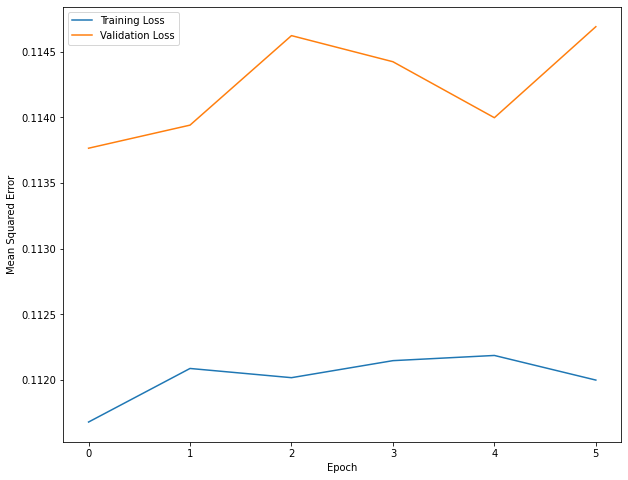

In [50]:
import matplotlib.pyplot as plt

def plot_the_loss_curve(mse_train, mse_val):
  """Plot a curve of loss vs. epoch."""

  plt.figure(figsize=(10, 8))
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(mse_train, label="Training Loss")
  plt.plot(mse_val, label="Validation Loss")
  plt.legend()
  # plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show() 

mse_train = history.history['mean_absolute_error']
mse_val = history.history['val_mean_absolute_error']

plot_the_loss_curve(mse_train, mse_val)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.576214 to fit



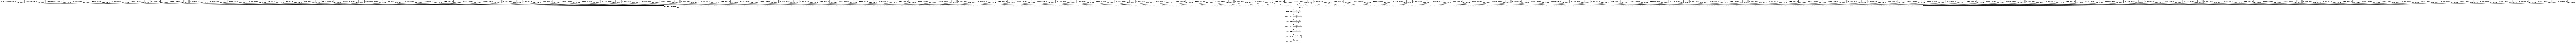

In [38]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)